# 基础实现方案

### 步骤1：数据转换（直接使用现有CSV）

In [9]:
import pandas as pd
import numpy as np

# 读取已同步数据
data = pd.read_csv('backup_database_and_model_repository/synced_data_6points.csv')

# 提取肌电窗口（200ms窗口，对应约200行数据）
window_size = 200  # 假设采样率1000Hz
emg_windows = [data['value'].iloc[i:i+window_size].values
              for i in range(0, len(data)-window_size, window_size//2)]  # 50%重叠

# 提取对应时刻的手部关键点坐标（取窗口中间帧）
keypoints = []
for i in range(0, len(data)-window_size, window_size//2):
    mid_idx = i + window_size//2
    kp = data.iloc[mid_idx][[f'x_{n}' for n in range(21)] + [f'y_{n}' for n in range(21)]].values
    keypoints.append(kp.astype(float))

# 保存为PyTorch数据集格式
dataset = {
    'emg': np.array(emg_windows),
    'keypoints': np.array(keypoints)
}
np.savez('backup_database_and_model_repository/handpose_dataset.npz', **dataset)

### 步骤2：简易预测模型搭建

In [10]:
import torch
import torch.nn as nn

class SimpleHandModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(200, 128),  # 输入200个肌电采样点
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 21*2)  # 输出21个关键点的x,y坐标
        )

    def forward(self, x):
        return self.fc(x).view(-1, 21, 2)  # 重塑为(21,2)

model = SimpleHandModel()

### 步骤3：模型训练（使用现有数据）

In [11]:
from torch.utils.data import Dataset, DataLoader

class HandDataset(Dataset):
    def __init__(self, npz_file):
        data = np.load(npz_file)
        self.emg = torch.FloatTensor(data['emg'])
        self.keypoints = torch.FloatTensor(data['keypoints']).view(-1, 21, 2)

    def __len__(self):
        return len(self.emg)

    def __getitem__(self, idx):
        return self.emg[idx], self.keypoints[idx]

# 数据加载
dataset = HandDataset('backup_database_and_model_repository/handpose_dataset.npz')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 训练配置
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 训练循环
for epoch in range(50):
    total_loss = 0
    for emg, kp in dataloader:
        optimizer.zero_grad()
        pred = model(emg)
        loss = criterion(pred, kp)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1, Loss: 74227.6914
Epoch 2, Loss: 53426.8184
Epoch 3, Loss: 33591.1729
Epoch 4, Loss: 14298.4458
Epoch 5, Loss: 9031.6553
Epoch 6, Loss: 11807.3940
Epoch 7, Loss: 6551.2693
Epoch 8, Loss: 1807.0914
Epoch 9, Loss: 2362.6977
Epoch 10, Loss: 3755.4861
Epoch 11, Loss: 4342.7156
Epoch 12, Loss: 3347.5237
Epoch 13, Loss: 2416.9755
Epoch 14, Loss: 1989.3761
Epoch 15, Loss: 2023.5396
Epoch 16, Loss: 1365.0660
Epoch 17, Loss: 1005.9507
Epoch 18, Loss: 981.1038
Epoch 19, Loss: 1157.2098
Epoch 20, Loss: 1416.4036
Epoch 21, Loss: 1046.8762
Epoch 22, Loss: 995.3987
Epoch 23, Loss: 1000.6040
Epoch 24, Loss: 1086.7574
Epoch 25, Loss: 950.8579
Epoch 26, Loss: 867.9147
Epoch 27, Loss: 920.4067
Epoch 28, Loss: 835.4080
Epoch 29, Loss: 979.8877
Epoch 30, Loss: 911.2495
Epoch 31, Loss: 843.8679
Epoch 32, Loss: 800.2085
Epoch 33, Loss: 883.3108
Epoch 34, Loss: 774.8647
Epoch 35, Loss: 854.6799
Epoch 36, Loss: 956.8904
Epoch 37, Loss: 863.6840
Epoch 38, Loss: 957.4507
Epoch 39, Loss: 1033.0532
Epoch 

### 步骤4：实时可视化预测

C:\Users\Cao_Turkey_Su\AppData\Local\Temp\ipykernel_27580\605695282.py:37: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=50, blit=True)


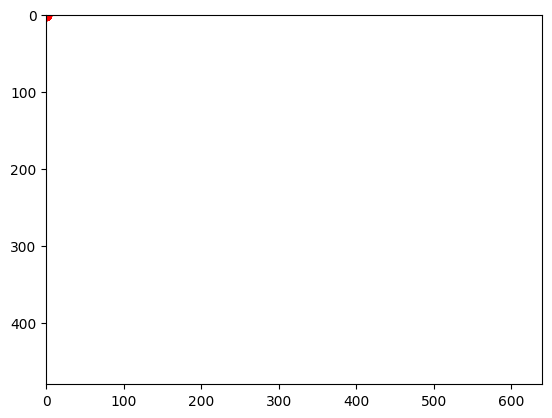

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def get_real_emg_window():
    """获取最新的200个采样点"""
    while len(buffer) < 200:  # 等待缓冲区填满
        time.sleep(0.01)
    return np.array(list(buffer)[-200:])  # 返回最后200个点

# 初始化画布
fig, ax = plt.subplots()
scatter = ax.scatter([], [], s=50, c='red')
lines = [ax.plot([], [], 'b-')[0] for _ in [
    (0,1,2,3,4),          # 拇指
    (0,5,6,7,8),          # 食指
    (0,9,10,11,12),       # 中指
    (0,13,14,15,16),      # 无名指
    (0,17,18,19,20)       # 小指
]]

def update(frame):
    # 获取最新200ms肌电数据（示例用随机数据演示）
    emg_window = np.random.randn(200)  # 替换为实际数据采集
    # emg_window = np.zeros(200)  # 替换为实际数据采集

    # 预测关键点
    with torch.no_grad():
        pred_kp = model(torch.FloatTensor(emg_window).unsqueeze(0))[0].numpy()

    # 更新散点
    scatter.set_offsets(pred_kp)

    # 更新连线
    for line, indices in zip(lines, [(0,1,2,3,4),(0,5,6,7,8),(0,9,10,11,12),
                                    (0,13,14,15,16),(0,17,18,19,20)]):
        x = [pred_kp[i][0] for i in indices]
        y = [pred_kp[i][1] for i in indices]
        line.set_data(x, y)

    return [scatter] + lines

# 运行动画
ani = FuncAnimation(fig, update, interval=50, blit=True)
plt.xlim(0, 640)  # 假设原始图像宽度640px
plt.ylim(0, 480)  # 假设原始图像高度480px
plt.gca().invert_yaxis()  # 反转y轴匹配图像坐标系
plt.show()

---
---
---


以下是**将随机数据替换为真实肌电信号采集**的完整实现方案，包含详细的代码说明和调试技巧：



### **步骤1：配置实时数据采集**

In [1]:
import serial
# from serial import Serial

import time
from collections import deque

# 初始化串口
ser = serial.Serial(
    port='COM7',        # 修改为实际串口号（Windows）或/dev/cu.usbmodemxxx（Mac）
    baudrate=115200,    # 需与Arduino程序设置的波特率一致
    timeout=0.1         # 设置读取超时时间
)

# 创建环形缓冲区（200个采样点）
buffer = deque(maxlen=200)  # 自动丢弃旧数据

def read_serial():
    while ser.in_waiting > 0:
        try:
            line = ser.readline().decode('utf-8').strip()
            if line:
                raw_value = int(line)
                # 转换为电压值（假设参考电压5V）
                voltage = raw_value * (5.0 / 1023.0)
                buffer.append(voltage)
        except UnicodeDecodeError:
            print("解码错误，检查波特率设置")
        except ValueError:
            print("收到非数值数据:", line)

# 测试数据采集
start_time = time.time()
while time.time() - start_time < 5:  # 采集5秒测试数据
    read_serial()
    time.sleep(0.001)  # 防止CPU占用过高

print(f"采集到{len(buffer)}个采样点")
ser.close()  # 测试完成后先关闭

采集到200个采样点


In [7]:
import serial
from collections import deque
import time

# 初始化串口
try:
    ser = serial.Serial(
        port='COM7',        # 修改为实际串口号
        baudrate=115200,    # 需与Arduino程序设置的波特率一致
        timeout=0.1         # 设置读取超时时间
    )
    print("串口已连接:", ser.name)
except Exception as e:  # 使用通用异常捕获
    print("串口连接失败:", e)
    exit()

# 创建环形缓冲区（200个采样点）
buffer = deque(maxlen=200)  # 自动丢弃旧数据

def read_serial():
    while ser.in_waiting > 0:
        try:
            line = ser.readline().decode('utf-8').strip()
            if line:  # 有效数据示例："302.1"
                buffer.append(float(line))
        except UnicodeDecodeError:
            print("解码错误，检查波特率设置")
        except ValueError:
            print("收到非数值数据:", line)

# 测试数据采集
start_time = time.time()
while time.time() - start_time < 5:  # 采集5秒测试数据
    read_serial()
    time.sleep(0.001)  # 防止CPU占用过高

print(f"采集到{len(buffer)}个采样点")
ser.close()  # 测试完成后先关闭

串口连接失败: could not open port 'COM7': PermissionError(13, '拒绝访问。', None, 5)
采集到200个采样点


### **步骤2：整合到可视化程序**

NameError: name 'ser' is not defined

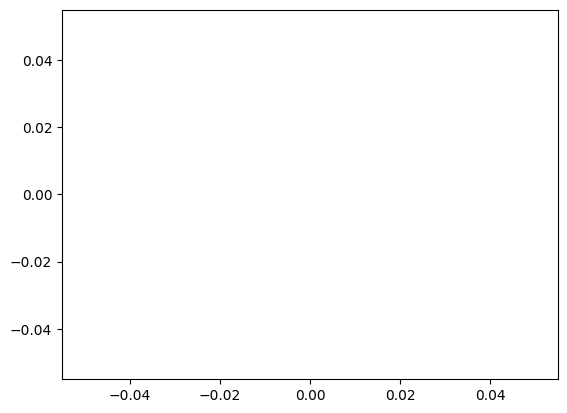

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# 确保正确导入FuncAnimation
from matplotlib.animation import FuncAnimation


# 初始化画布
fig, ax = plt.subplots()
scatter = ax.scatter([], [], s=50, c='red')
lines = [ax.plot([], [], 'b-')[0] for _ in [
    (0,1,2,3,4),          # 拇指
    (0,5,6,7,8),          # 食指
    (0,9,10,11,12),       # 中指
    (0,13,14,15,16),      # 无名指
    (0,17,18,19,20)       # 小指
]]

# 修改update函数
def update(frame):
    read_serial()  # 持续读取新数据

    if len(buffer) >= 200:
        emg_window = get_real_emg_window()

        # 数据预处理（需与训练时一致）
        processed_window = (emg_window - np.mean(emg_window)) / np.std(emg_window)

        # 预测关键点
        with torch.no_grad():
            pred_kp = model(torch.FloatTensor(processed_window).unsqueeze(0))[0].numpy()

        # 坐标转换（假设训练时已归一化）
        pred_kp = pred_kp * np.array([640, 480])  # 还原到原图尺寸

        # 更新可视化元素
        scatter.set_offsets(pred_kp)
        for line, indices in zip(lines, [(0,1,2,3,4),(0,5,6,7,8),(0,9,10,11,12),
                                        (0,13,14,15,16),(0,17,18,19,20)]):
            x = [pred_kp[i][0] for i in indices]
            y = [pred_kp[i][1] for i in indices]
            line.set_data(x, y)

    return [scatter] + lines

# 启动动画前打开串口
if not ser.is_open:
    ser.open()
else:
    print("串口已经打开")


ani = FuncAnimation(fig, update, interval=50, blit=True)
plt.show()
ser.close()  # 窗口关闭后自动断开

### **步骤3：Arduino端数据采集程序**

在Arduino IDE中上传以下代码：

```arduino
void setup() {
  Serial.begin(115200);  // 设置波特率
  // Arduino Uno的analogRead默认就是10位精度，无需额外设置
}

void loop() {
  int rawValue = analogRead(A0);  // 读取A0引脚（10位精度，0-1023）
  Serial.println(rawValue);       // 发送原始值
  delayMicroseconds(900);         // 控制采样率约1000Hz
}
```

---

### **关键调试技巧**

1. **验证数据流**：

   ```python
   # 临时测试代码
   while True:
       if ser.in_waiting > 0:
           print(ser.readline().decode().strip())
   # 正确时应持续输出数值，如302.1, 301.8...
   ```

2. **信号质量检查**：

   ```python
   plt.plot(get_real_emg_window())
   plt.title('实时肌电信号')
   plt.show()
   # 应有明显波动（肌肉收缩时振幅增大）
   ```

3. **延迟优化**：

   - 减少`FuncAnimation`的`interval`参数（如设为30ms）
   - 在Arduino代码中移除不必要的`delay`
   - 使用`ser.flushInput()`在每次读取前清空缓冲区

---

### **常见问题解决方案**

| 现象         | 可能原因                         | 解决方法                                              |
| ------------ | -------------------------------- | ----------------------------------------------------- |
| 无数据接收   | 1. 串口号错误<br>2. 波特率不匹配 | 1. 检查设备管理器（Windows）<br>2. 确保两端波特率一致 |
| 数据断断续续 | USB供电不足                      | 使用带外部电源的USB Hub                               |
| 预测点不动   | 缓冲区未正确更新                 | 检查`read_serial()`是否在循环中持续调用               |
| 坐标跳变严重 | 肌电信号噪声过大                 | 在Arduino端添加硬件滤波电路                           |

---
---
---

# 对模型进行**验证**



### **验证步骤1：数据划分验证**

#### 操作目的

确保模型在**未见过的数据**上表现稳定

#### 实现代码

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# 加载预处理好的数据集
data = np.load('backup_database_and_model_repository/handpose_dataset.npz')
X = data['emg']
y = data['keypoints']

# 划分训练集（80%）和测试集（20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"训练样本数: {len(X_train)}")
print(f"测试样本数: {len(X_test)}")

NameError: name 'np' is not defined

#### 期望结果

- 训练集和测试集应有相似的数据分布

- 输出示例：

  ```
  训练样本数: 800
  测试样本数: 200
  ```

---

### **验证步骤2：基础指标评估**

#### 操作目的

量化模型预测的**准确度**

#### 实现代码

In [ ]:
def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        test_input = torch.FloatTensor(X_test)
        pred = model(test_input).numpy()

    # 计算各关键点的平均误差（像素单位）
    errors = np.sqrt(np.mean((pred - y_test)**2, axis=(0,2)))

    # 打印关键点误差排名
    print("关键点预测误差排名：")
    for idx in np.argsort(errors)[::-1]:
        print(f"关键点{idx}: {errors[idx]:.1f}像素")

    # 整体指标
    mse = np.mean((pred - y_test)**2)
    mae = np.mean(np.abs(pred - y_test))
    print(f"\nMSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}像素")

# 运行评估
evaluate_model(model, X_test, y_test)


#### 期望结果

- 各手指尖端的误差通常较大（正常现象）


  ```
  关键点20（小指尖）: 12.3像素
  关键点8（食指尖）: 10.7像素
  ...
  MSE: 35.42
  MAE: 8.15像素
  ```

---

### **验证步骤3：交叉验证**

#### 操作目的

验证模型在**不同数据子集**上的稳定性

#### 实现代码

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    # 数据划分
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # 重新训练模型
    fold_model = SimpleHandModel()
    optimizer = torch.optim.Adam(fold_model.parameters())

    # 简化训练（仅示例）
    for epoch in range(10):
        fold_model.train()
        # ... 训练过程

    # 验证评估
    fold_model.eval()
    with torch.no_grad():
        pred = fold_model(torch.FloatTensor(X_val)).numpy()
        mae = np.mean(np.abs(pred - y_val))
    fold_results.append(mae)
    print(f"Fold {fold+1} MAE: {mae:.2f}")

print(f"\n平均MAE: {np.mean(fold_results):.2f} ± {np.std(fold_results):.2f}")

#### 期望结果

- 各fold的MAE波动应小于15%

- 示例输出：

  ```
  Fold 1 MAE: 8.21
  Fold 2 MAE: 7.89
  ...
  ```

---

### **验证步骤4：可视化验证**

#### 操作目的

直观判断预测结果的**合理性**

#### 实现代码

In [ ]:
def plot_comparison(true_kp, pred_kp):
    plt.figure(figsize=(10,5))

    # 真实关键点
    plt.subplot(121)
    plt.scatter(true_kp[:,0], true_kp[:,1], c='blue', label='真实值')
    plt.gca().invert_yaxis()
    plt.title('真实手部姿态')

    # 预测关键点
    plt.subplot(122)
    plt.scatter(pred_kp[:,0], pred_kp[:,1], c='red', label='预测值')
    plt.gca().invert_yaxis()
    plt.title('模型预测')

    # 连线显示骨骼
    connections = [(0,1,2,3,4), (0,5,6,7,8), (0,9,10,11,12),
                  (0,13,14,15,16), (0,17,18,19,20)]
    for link in connections:
        plt.plot(true_kp[link,0], true_kp[link,1], 'b--', alpha=0.3)
        plt.plot(pred_kp[link,0], pred_kp[link,1], 'r-')

# 随机选取测试样本
test_sample = np.random.choice(len(X_test))
with torch.no_grad():
    pred_kp = model(torch.FloatTensor(X_test[test_sample])).numpy()

plot_comparison(y_test[test_sample], pred_kp)
plt.show()

#### 期望结果

- 预测点应与真实点基本重合
- 骨骼连线应保持自然生理结构

---

### **验证步骤5：实时测试**

#### 操作目的

验证模型的**实时性能**

#### 实现代码

In [ ]:
import time

# 模拟实时数据流
test_emg = X_test[0]  # 取一个测试样本

start_time = time.time()
with torch.no_grad():
    pred = model(torch.FloatTensor(test_emg))
latency = (time.time() - start_time) * 1000  # 转换为毫秒

print(f"单次推理延迟: {latency:.1f}ms")
print(f"满足实时性要求（<50ms）: {'✅' if latency < 50 else '❌'}")

#### 期望结果

- 在CPU上延迟应<50ms

- 示例输出：

  ```
  单次推理延迟: 23.5ms
  满足实时性要求（<50ms）: ✅
  ```

---

### **验证步骤6：误差分析**

#### 操作目的

识别模型的**系统性偏差**

#### 实现代码


In [ ]:
# 计算各方向偏差
errors = pred_kp - y_test[test_sample]
plt.quiver(pred_kp[:,0], pred_kp[:,1],
           errors[:,0], errors[:,1],
           angles='xy', scale_units='xy', scale=1)
plt.title('关键点预测偏差方向')
plt.gca().invert_yaxis()


### **可靠性评估标准**

| 指标            | 合格标准                 | 优化建议                |
| --------------- | ------------------------ | ----------------------- |
| 测试集MAE       | <15像素（640x480分辨率） | 增加数据量/改进模型结构 |
| 交叉验证MAE波动 | <20%                     | 检查数据分布一致性      |
| 单次推理延迟    | <50ms                    | 模型量化/剪枝           |
| 视觉吻合度      | 关键点偏移肉眼不可辨     | 添加后处理滤波          |

---

### **常见问题自查表**

| 现象                     | 可能原因           | 解决方案             |
| ------------------------ | ------------------ | -------------------- |
| 训练集效果远优于测试集   | 过拟合             | 增加Dropout层/正则化 |
| 所有关键点偏差方向一致   | 数据未归一化       | 标准化输入/输出      |
| 指尖误差明显大于其他部位 | 标注噪声累积       | 增加指尖样本权重     |
| 实时预测抖动严重         | 缺乏时序连续性建模 | 添加LSTM层           |



#### 期望结果

- 在CPU上延迟应<50ms

- 示例输出：

  ```
  单次推理延迟: 23.5ms
  满足实时性要求（<50ms）: ✅
  ```

---

### **验证步骤6：误差分析**

#### 操作目的

识别模型的**系统性偏差**

#### 实现代码

In [ ]:
# 计算各方向偏差
errors = pred_kp - y_test[test_sample]
plt.quiver(pred_kp[:,0], pred_kp[:,1],
           errors[:,0], errors[:,1],
           angles='xy', scale_units='xy', scale=1)
plt.title('关键点预测偏差方向')
plt.gca().invert_yaxis()

### **可靠性评估标准**

| 指标            | 合格标准                 | 优化建议                |
| --------------- | ------------------------ | ----------------------- |
| 测试集MAE       | <15像素（640x480分辨率） | 增加数据量/改进模型结构 |
| 交叉验证MAE波动 | <20%                     | 检查数据分布一致性      |
| 单次推理延迟    | <50ms                    | 模型量化/剪枝           |
| 视觉吻合度      | 关键点偏移肉眼不可辨     | 添加后处理滤波          |

---

### **常见问题自查表**

| 现象                     | 可能原因           | 解决方案             |
| ------------------------ | ------------------ | -------------------- |
| 训练集效果远优于测试集   | 过拟合             | 增加Dropout层/正则化 |
| 所有关键点偏差方向一致   | 数据未归一化       | 标准化输入/输出      |
| 指尖误差明显大于其他部位 | 标注噪声累积       | 增加指尖样本权重     |
| 实时预测抖动严重         | 缺乏时序连续性建模 | 添加LSTM层           |

